In [1]:
from keras.utils import np_utils
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import shutil
import importlib

import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Reshape
from keras.regularizers import l2
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input

import sys
sys.path.append('..')

from sklearn.datasets import load_files
import pandas as pd
pd.set_option("display.max_colwidth", 75)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/tutysara/anaconda2/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
from bcolzutils import *
from util import *

In [24]:
alpha = 1
dropout=1e-3
num_classes = 3
lr=1e-3
momentum=0.9
weight_decay = 1e-5
num_classes = 3
percent = 0.025
batch_size = 32

arch = "vgg19"
basedir="/media/hdd/datastore/t4sa"

valid_name = basedir + '/valid_data'
test_name = basedir + '/test_data'
train_name = basedir +'/train_data' 

bnf_valid_name = basedir + f'/bottleneck_features_{arch}_valid'
bnf_test_name = basedir + f'/bottleneck_features_{arch}_test' 
bnf_train_name = basedir + f'/bottleneck_features_{arch}_train'

test_prefix = ""
top_model_test_result = f'bottleneck_features_{arch}_result.npz'
full_model_test_result = f'finetune_fullmodel_{arch}_result{test_prefix}.npz'
top_model_weight_path = f'saved_models/weights.best.topmodel.{arch}.hdf5'
full_model_weight_path = f'saved_models/weights.best.fullmodel.{arch}{test_prefix}.hdf5'

top_model_loss_history = f'train_top_model_{arch}_loss_history.csv'
top_model_weight_path = f'finetune_fullmodel_{arch}_loss_history.csv'

top_model_sys_usage_log = "train_top_model_{arch}.ps.log"
full_model_sys_usage_log = "finetune_full_model_{arch}.ps.log"

In [17]:
print(bnf_valid_name)
print(bnf_test_name)
print(bnf_train_name)
print(full_model_test_result)
print(top_model_test_result)

/media/hdd/datastore/t4sa/bottleneck_features_vgg19_valid
/media/hdd/datastore/t4sa/bottleneck_features_vgg19_test
/media/hdd/datastore/t4sa/bottleneck_features_vgg19_train
finetune_fullmodel_vgg19_result.npz
bottleneck_features_vgg19_result.npz


In [18]:
# load TTD to cross verify
ttd_basedir="/home/tutysara/src/myprojects/senti/dataset"
ttd_data_idx_path = ttd_basedir+ "/twitter_five_agrees.txt"
col_names = ["X", "y"]
ttd_data_df = pd.read_csv(ttd_data_idx_path, sep=" ", header=None, names=col_names)
ttd_data_df.X = ttd_data_df.X.apply(lambda x: ttd_basedir+"/Agg_AMT_Candidates/"+x)
print(ttd_data_df.shape)
ttd_data_df.head()

(882, 2)


,X,y
0,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/28800526...,0
1,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/33547480...,1
2,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/27176682...,1
3,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/10096570...,1
4,/home/tutysara/src/myprojects/senti/dataset/Agg_AMT_Candidates/13247920...,1


In [19]:
# read from disk and check size
valid_data = bcolz.carray(rootdir= valid_name+'_data.bclz', mode='r')
test_data = bcolz.carray(rootdir= test_name + '_data.bclz', mode='r')
train_data = bcolz.carray(rootdir= train_name+ '_data.bclz', mode='r')


valid_labels = bcolz.carray(rootdir= valid_name+'_labels.bclz', mode='r')
test_labels = bcolz.carray(rootdir= test_name + '_labels.bclz', mode='r')
train_labels = bcolz.carray(rootdir= train_name+ '_labels.bclz', mode='r')

print("Raw data in bcolz format")
print(valid_data.shape)
print(test_data.shape)
print(train_data.shape)

print(valid_labels.shape)
print(test_labels.shape)
print(train_labels.shape)

Raw data in bcolz format
(51000, 224, 224, 3)
(51000, 224, 224, 3)
(368586, 224, 224, 3)
(51000, 3)
(51000, 3)
(368586, 3)


In [20]:
# convert it to bottleneck features using 
#%ipython tx2_bottleneck_mobilenet.py

In [21]:
## Read it back from disk and check size
bnf_valid_data = bcolz.carray(rootdir=f'{bnf_valid_name}_data.bclz', mode='r')
bnf_test_data = bcolz.carray(rootdir=f'{bnf_test_name}_data.bclz', mode='r')
bnf_train_data = bcolz.carray(rootdir=f'{bnf_train_name}_data.bclz', mode='r')

bnf_valid_labels = bcolz.carray(rootdir=f'{bnf_valid_name}_labels.bclz', mode='r')
bnf_test_labels = bcolz.carray(rootdir=f'{bnf_test_name}_labels.bclz', mode='r')
bnf_train_labels = bcolz.carray(rootdir=f'{bnf_train_name}_labels.bclz', mode='r')


print("Bottle Neck Features data in bcolz format")
print(bnf_valid_data.shape)
print(bnf_test_data.shape)
print(bnf_train_data.shape)


print(bnf_valid_labels.shape)
print(bnf_test_labels.shape)
print(bnf_train_labels.shape)

Bottle Neck Features data in bcolz format
(51000, 7, 7, 512)
(51000, 7, 7, 512)
(368586, 7, 7, 512)
(51000, 3)
(51000, 3)
(368586, 3)


In [22]:
## make a generator of loaded bottleneck features
bnf_train_gen =bcolz_data_generator(bnf_train_data, bnf_train_labels, batch_size=batch_size)
bnf_valid_gen =bcolz_data_generator(bnf_valid_data, bnf_valid_labels, batch_size=batch_size)
bnf_test_gen =bcolz_data_generator(bnf_test_data, bnf_test_labels, batch_size=batch_size) 

In [23]:
classes = num_classes

top_model = Sequential()
top_model.add(Flatten(name='flatten', input_shape=(7, 7, 512)))
top_model.add(Dense(4096, activation='relu', name='fc1', kernel_regularizer=l2(weight_decay)))
top_model.add(Dropout(0.5))
top_model.add(Dense(4096, activation='relu', name='fc2', kernel_regularizer=l2(weight_decay)))
top_model.add(Dropout(0.5))
top_model.add(Dense(classes, activation='softmax', name='predictions'))

top_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=lr, momentum=momentum),
              metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
predictions (Dense)          (None, 3)                 12291     
Total params: 119,558,147
Trainable params: 119,558,147
Non-trainable params: 0
______________________________________________________________

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='../saved_models/weights.best.topmodel.vgg19_test.hdf5', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
top_model.fit_generator(bnf_train_gen,
          steps_per_epoch= int(1 + (bnf_train_data.shape[0] * percent // batch_size)),
          epochs=15,
          validation_data=bnf_valid_gen,
          validation_steps= (1 + (bnf_valid_data.shape[0] * percent // batch_size)),
          callbacks=[early_stopping, checkpointer])

Epoch 1/15
287/288 [============================>.] - ETA: 0s - loss: 10.9084 - acc: 0.328875
Epoch 00001: val_loss improved from inf to 11.00390, saving model to ../saved_models/weights.best.topmodel.vgg19_test.hdf5
288/288 [==============================] - 52s 181ms/step - loss: 10.9077 - acc: 0.3289 - val_loss: 11.0039 - val_acc: 0.3242
Epoch 2/15
287/288 [============================>.] - ETA: 0s - loss: 10.7575 - acc: 0.3395
Epoch 00002: val_loss did not improve
288/288 [==============================] - 22s 76ms/step - loss: 10.7520 - acc: 0.3398 - val_loss: 11.0920 - val_acc: 0.3187
Epoch 3/15
287/288 [============================>.] - ETA: 0s - loss: 10.7768 - acc: 0.3383
Epoch 00003: val_loss improved from 11.00390 to 10.73944, saving model to ../saved_models/weights.best.topmodel.vgg19_test.hdf5
288/288 [==============================] - 40s 138ms/step - loss: 10.7818 - acc: 0.3380 - val_loss: 10.7394 - val_acc: 0.3406
Epoch 4/15
287/288 [============================>.] - ET

ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096]
	 [[Node: fc1_2/Square = Square[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fc1_2/kernel/read)]]
	 [[Node: loss_2/add_1/_343 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_557_loss_2/add_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'fc1_2/Square', defined at:
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-863643419fb2>", line 5, in <module>
    top_model.add(Dense(4096, activation='relu', name='fc1', kernel_regularizer=l2(weight_decay)))
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/keras/models.py", line 492, in add
    output_tensor = layer(self.outputs[0])
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/keras/engine/topology.py", line 590, in __call__
    self.build(input_shapes[0])
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/keras/layers/core.py", line 842, in build
    constraint=self.kernel_constraint)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/keras/engine/topology.py", line 416, in add_weight
    self.add_loss(regularizer(weight))
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/keras/regularizers.py", line 42, in __call__
    regularization += K.sum(self.l2 * K.square(x))
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1432, in square
    return tf.square(x)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 449, in square
    return gen_math_ops.square(x, name=name)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4567, in square
    "Square", x=x, name=name)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/tutysara/anaconda2/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[25088,4096]
	 [[Node: fc1_2/Square = Square[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fc1_2/kernel/read)]]
	 [[Node: loss_2/add_1/_343 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_557_loss_2/add_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
# train the model using
# ipython tx2_bottleneck_mobilenet.py
#
#syrupy.py --separator=, --no-align --no-raw-process-log  ipython train_top_model_with_bottleneck_features_mobilenet.py

In [13]:
top_model.load_weights(top_model_weight_path)

In [14]:
# read back and check
npzfile = np.load(top_model_test_result)
y_true = npzfile['y_true']
y_pred = npzfile['y_pred']
print(y_true.shape)
print(y_pred.shape)

(51000, 3)
(51000, 3)


In [15]:
# report test accuracy
test_accuracy = 100*np.sum(np.argmax(y_pred, axis=1)==np.argmax(y_true, axis=1))/len(y_true)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.5020%


In [16]:
# report test accuracy on TTD
mobilenet_feature_ext = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
mobilenet_feature_ext._make_predict_function()

ttd_X1 = ttd_data_df.X.as_matrix()
ttd_X2 = mobilenet_preprocess_input(paths_to_tensor(ttd_X1))
ttd_X = mobilenet_feature_ext.predict(ttd_X2)

In [17]:
ttd_y_pred = top_model.predict(ttd_X)
ttd_y_pred_two_classes=ttd_y_pred[:,[0,2]]
ttd_y_true = ttd_data_df.y.as_matrix()

In [18]:
print(ttd_X.shape)
print(ttd_y_pred.shape)
print(ttd_y_true.shape) 

(882, 7, 7, 1024)
(882, 3)
(882,)


In [19]:
ttd_test_accuracy = 100*np.sum(np.argmax(ttd_y_pred_two_classes, axis=1)==ttd_y_true)/len(ttd_y_true)
print('TTD Test accuracy: %.4f%%' % ttd_test_accuracy)

TTD Test accuracy: 70.5215%


In [32]:
top_model_loss_history_df = pd.read_csv(top_model_loss_history)
top_model_loss_history_df.tail()

,epoch,acc,loss,val_acc,val_loss
3,3,0.461816,1.056190,0.451725,1.069901
4,0,0.456235,1.067132,0.452157,1.068786
5,1,0.461480,1.056275,0.452235,1.068681
6,2,0.461295,1.056248,0.451451,1.070490
7,3,0.461805,1.056281,0.451922,1.069107


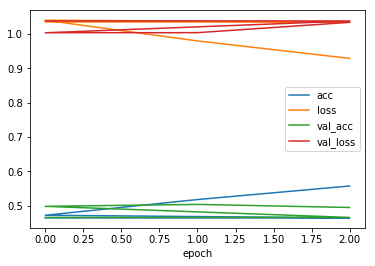

In [21]:
top_model_loss_history_df.plot(x=0)

In [39]:
top_model_sys_usage_df = pd.read_csv(top_model_sys_usage_log)
top_model_sys_usage_df.drop(columns=["CMD"], inplace=True)
top_model_sys_usage_df.tail()

,PID,DATE,TIME,ELAPSED,CPU,MEM,RSS,VSIZE
6470,7864,2018-02-21,20:54:08,01:50:36,31.3,2.5,822952,16444208
6471,7864,2018-02-21,20:54:09,01:50:37,31.3,2.5,822952,16444208
6472,7864,2018-02-21,20:54:10,01:50:38,31.3,2.5,822952,16444208
6473,7864,2018-02-21,20:54:11,01:50:39,31.3,2.5,822952,16444208
6474,7864,2018-02-21,20:54:12,01:50:40,31.3,0.0,0,0


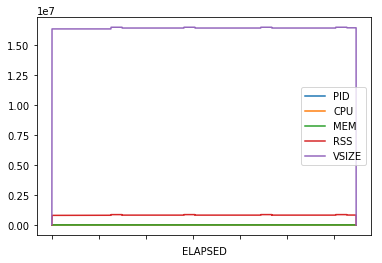

In [43]:
top_model_sys_usage_df.plot(x=3)

In [28]:
# fine tune on full model
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

mobilenet_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# CREATE AN "REAL" MODEL FROM Mobilenet
# BY COPYING ALL THE LAYERS OF Mobilenet
model = Sequential()
for l in mobilenet_model.layers:
    model.add(l)


# CONCATENATE THE TWO MODELS
model.add(top_model)

# LOCK THE TOP CONV LAYERS
for layer in model.layers:
    layer.trainable = True
    #print(layer.name)

# COMPILE THE MODEL
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=lr, momentum=momentum),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [23]:
model.load_weights(full_model_weight_path)

In [24]:
# load full mode result
npzfile = np.load(full_model_test_result)
y_true = npzfile['y_true']
y_pred = npzfile['y_pred']
log.debug(y_true.shape)
log.debug(y_pred.shape)

In [25]:
# report test accuracy
test_accuracy = 100*np.sum(np.argmax(y_pred, axis=1)==np.argmax(y_true, axis=1))/len(y_true)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 49.4882%


In [26]:
# report test accuracy on TTD
ttd_X1 = ttd_data_df.X.as_matrix()
ttd_y_pred = model.predict(paths_to_tensor(ttd_X1))
    
ttd_y_pred_two_classes=ttd_y_pred[:,[0,2]]
ttd_y_true = ttd_data_df.y.as_matrix()

In [27]:
ttd_test_accuracy = 100*np.sum(np.argmax(ttd_y_pred_two_classes, axis=1)==ttd_y_true)/len(ttd_y_true)
print('TTD Test accuracy: %.4f%%' % ttd_test_accuracy)

TTD Test accuracy: 76.4172%


In [33]:
full_model_loss_history_df = pd.read_csv(finetune_model_loss_history)
full_model_loss_history_df.tail()

,epoch,acc,loss,val_acc,val_loss
1,1,0.464361,1.035470,0.465784,1.038422
2,2,0.464486,1.035522,0.465784,1.038422
3,0,0.472118,1.040529,0.498137,1.004036
4,1,0.517895,0.980233,0.503725,1.004360
5,2,0.557379,0.929401,0.494765,1.034429


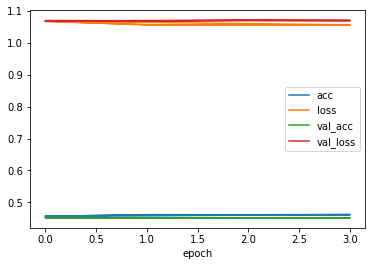

In [34]:
top_model_loss_history_df.plot(x=0)

In [37]:
full_model_sys_usage_df = pd.read_csv(full_model_sys_usage_log)
full_model_sys_usage_df.drop(columns=["CMD"], inplace=True)
full_model_sys_usage_df.tail()

,PID,DATE,TIME,ELAPSED,CPU,MEM,RSS,VSIZE
11233,21886,2018-02-22,00:53:15,03:11:17,105.0,6.0,1991004,21606684
11234,21886,2018-02-22,00:53:16,03:11:18,105.0,6.0,1991004,21606684
11235,21886,2018-02-22,00:53:17,03:11:19,105.0,6.0,1991004,21606684
11236,21886,2018-02-22,00:53:18,03:11:20,105.0,6.0,1989180,21548544
11237,21886,2018-02-22,00:53:19,03:11:21,105.0,0.0,0,0
